# Image Classification - Search Space and Hyperparameter Optimization (HPO)

한 줄의 코드만으로 쉽게 이미지 분류를 수행할 수 있지만, 보다 높은 분류 성능이 필요하다면 어떤 방법이 있을까요?

AutoGluon은 아키텍처 검색을 포함한 적절한 검색 공간(search space)을 찾는 전략과 하이퍼파라메터 최적화(HPO; Hyperparameter Optimization)를 동시에 지원하며, 이를
몇 줄의 코드로 간단히 수행합니다. 핸즈온을 통해 체험해 보시죠!

- `autogluon.core.searcher`: 최적 하이퍼파라메터 검색 공간 탐색
- `autogluon.core.scheduler`: 개별 훈련 작업이 예약되는 방식을 조정하며, FIFO, Hyperband, RL(Reinforcement Learning) 스케줄링을 지원합니다.

Searcher와 Scheduler에 대한 좀 더 자세한 예제는 `5.hpo` 폴더의 예제들을 참조하세요.
- [Searcher 예제](../5.hpo/01_search_space.ipynb)
- [Scheduler에 예제](../5.hpo/02_scheduler.ipynb)

In [12]:
# !pip install --no-cache-dir horovod[pytorch,mxnet]

In [5]:
import autogluon.core as ag
from autogluon.vision import ImagePredictor

<br>

## 1. Data Preparation and Training

In [6]:
train_data, _, test_data = ImagePredictor.Dataset.from_folders('https://autogluon.s3.amazonaws.com/datasets/shopee-iet.zip')

data/
├── test/
└── train/


### Specify which Networks to Try

AutoGluon-Vision은 GluonCV와 연계하여 사전 훈련된 수많은 컴퓨터 비전 모델들을 제공하고 있습니다. 
아래 코드는 `autogluon.core.space.Categorical`로 검색 공간을 정의하는 예시를 보여줍니다.

In [7]:
# you may choose more than 70+ available model in the model zoo provided by GluonCV:
model_list = ImagePredictor.list_models()
model_list[:10]

('resnet18_v1',
 'resnet34_v1',
 'resnet50_v1',
 'resnet101_v1',
 'resnet152_v1',
 'resnet18_v2',
 'resnet34_v2',
 'resnet50_v2',
 'resnet101_v2',
 'resnet152_v2')

튜토리얼 목적이기 때문에 ResNet-18과 MobileNetV3-Small만 모델 후보로 사용하겠습니다. GPU 메모리가 충분하다면 batch_size를 더 크게 설정하셔도 됩니다.  

In [8]:
model = ag.Categorical('resnet18_v1b', 'mobilenetv3_small')
lr = ag.Categorical(1e-2, 1e-3)
batch_size = 8

### Search Algorithms

AutoGluon의 `autogluon.core.searcher`는 하이퍼파라미터 튜닝과 최적 아키텍처 검색에 대한 검색 전략을 지원합니다. 또한, `autogluon.core.scheduler`는 개별 훈련 작업이 예약되는 방식을 조정하며 0.5.1 버전에서는 랜덤 검색을 지원합니다.

In [9]:
hyperparameters = {
    'model': model, 
    'batch_size': batch_size, 
    'lr': lr, 
    'epochs': 2
}

아래 코드 셀에서 `num_trials=2`는 빠른 튜토리얼을 위해 추가한 파라메터이기에, 실제로 하이퍼파라메터 튜닝을 수행하실 때는 `num_trials`를 삭제해 주세요!

Reset labels to [0, 1, 2, 3]
Randomly split train_data into train[720]/validation[80] splits.
The number of requested GPUs is greater than the number of available GPUs.Reduce the number to 1
Starting HPO experiments


  0%|          | 0/2 [00:00<?, ?it/s]

In v0.6.0, ImagePredictor will no longer support training MXNet models. Please consider switching to specifying Torch models instead.
Users should ensure they update their code that depends on ImagePredictor when upgrading to future AutoGluon releases.
For more information, refer to this GitHub issue: https://github.com/awslabs/autogluon/issues/1560

modified configs(<old> != <new>): {
root.img_cls.model   resnet50_v1 != resnet18_v1b
root.train.early_stop_max_value 1.0 != inf
root.train.data_dir  ~/.mxnet/datasets/imagenet != auto
root.train.rec_val_idx ~/.mxnet/datasets/imagenet/rec/val.idx != auto
root.train.early_stop_patience -1 != 10
root.train.rec_train ~/.mxnet/datasets/imagenet/rec/train.rec != auto
root.train.epochs    10 != 2
root.train.batch_size 128 != 8
root.train.rec_val   ~/.mxnet/datasets/imagenet/rec/val.rec != auto
root.train.num_training_samples 1281167 != -1
root.train.lr        0.1 != 0.01
root.train.early_stop_baseline 0.0 != -inf
root.train.rec_train_idx ~/.mxnet

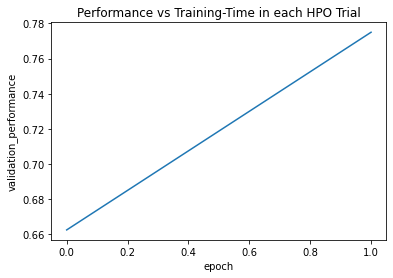

Finished, total runtime is 104.76 s
{ 'best_config': { 'estimator': <class 'gluoncv.auto.estimators.image_classification.image_classification.ImageClassificationEstimator'>,
                   'gpus': [0],
                   'img_cls': { 'batch_norm': False,
                                'last_gamma': False,
                                'model': 'resnet18_v1b',
                                'use_gn': False,
                                'use_pretrained': True,
                                'use_se': False},
                   'train': { 'batch_size': 8,
                              'crop_ratio': 0.875,
                              'data_dir': 'auto',
                              'dtype': 'float32',
                              'early_stop_baseline': -inf,
                              'early_stop_max_value': inf,
                              'early_stop_min_delta': 0.001,
                              'early_stop_patience': 10,
                              'epochs': 2,

Top-1 val acc: 0.775
CPU times: user 3min 21s, sys: 9.41 s, total: 3min 31s
Wall time: 1min 44s


In [10]:
%%time
predictor = ImagePredictor()
predictor.fit(
    train_data, time_limit=60*2, 
    hyperparameters=hyperparameters,
    hyperparameter_tune_kwargs={'num_trials': 2}
)
print('Top-1 val acc: %.3f' % predictor.fit_summary()['valid_acc'])

In [11]:
results = predictor.evaluate(test_data)
print('Test acc on hold-out data:', results)

Test acc on hold-out data: {'top1': 0.7875, 'top5': 1.0}
